# Let's Enhance! Video Upscaling Demo
This notebook demonstrates how to run the Super Resolution demo application, which
reconstructs high resolution 1080p video from a low resolution input. The demo uses the pre-trained `single-image-super-resolution-1033` model from the Open Model Zoo, which performs 3x upscale on 360x640 frames.

For more information please refer to the [model documentation](../../models/intel/index.md). To learn more about the research, please read the paper [An Attention-Based Approach for Single Image Super Resolution](https://arxiv.org/abs/1807.06779).

<img src="upscale.gif">

In [12]:
from __future__ import unicode_literals
from openvino.inference_engine import IENetwork, IECore
import youtube_dl
import requests
import numpy as np
import cv2 as cv
import ngraph as ng
from IPython.display import Image
import glob
import os

### Download ffmpeg
This demo requires ffmpeg to extract frames and create a new video that is enhanced by `single-image-super-resolution-1033` from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo). Download and install for Windows, MacOS or Linux here: http://ffmpeg.org/download.html

In [ ]:
# Use youtube-dl to download the sample video
ydl_opts = {'outtmpl': './original_1080p.mp4'}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://youtu.be/V8yS3WIkOrA'])

In [ ]:
# Make a directory for the video frames
!mkdir frames

In [ ]:
# Extract 640x360 frames from the original video file
!ffmpeg -i original_1080p.mp4 -vf "scale=640:360,fps=30" frames/sr_%04d.png

In [2]:
def download_model(url):
    local_filename = url.split('/')[-1]

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

/Users/ryanloney/code/repos/deblurgan_testing_notebook/test_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Download the models 
url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/1/single-image-super-resolution-1033/FP16-INT8/"
model_xml = 'single-image-super-resolution-1033.xml'
model_bin = 'single-image-super-resolution-1033.bin'

download_model(url + model_xml)
download_model(url + model_bin)

'single-image-super-resolution-1033.bin'

In [5]:
# This cell shows how to create a superres 1920x1080 image from a single 640x360 frame
img_path = 'frames/sr_0008.png'

# Read an image
img = cv.imread(img_path)

inp_h, inp_w = img.shape[0], img.shape[1]
out_h, out_w = inp_h * 3, inp_w * 3  # Do not change! This is how model works

# Setup network
model = 'single-image-super-resolution-1033'
net = IECore().read_network(model=model_xml, weights=model_bin)
function = ng.function_from_cnn(net)

# Reshape network to specific size
net.reshape({'0': [1, 3, inp_h, inp_w], '1': [1, 3, out_h, out_w]})

# Load network to device
ie = IECore()
exec_net = ie.load_network(net, 'CPU')

# Prepare input
inp = img.transpose(2, 0, 1)  # interleaved to planar (HWC -> CHW)
inp = inp.reshape(1, 3, inp_h, inp_w)
inp = inp.astype(np.float32)

# Prepare second input - bicubic resize of first input
resized_img = cv.resize(img, (out_w, out_h), interpolation=cv.INTER_CUBIC)
resized = resized_img.transpose(2, 0, 1)
resized = resized.reshape(1, 3, out_h, out_w)
resized = resized.astype(np.float32)

outs = exec_net.infer({'0': inp, '1': resized})

out = next(iter(outs.values()))

out = out.reshape(3, out_h, out_w).transpose(1, 2, 0)
out = np.clip(out * 255, 0, 255)
out = np.ascontiguousarray(out).astype(np.uint8)

cv.imwrite('img_source.png', img)
cv.imwrite('img_bicubic.png', resized_img)
cv.imwrite('img_superres.png', out)

reshaped


True

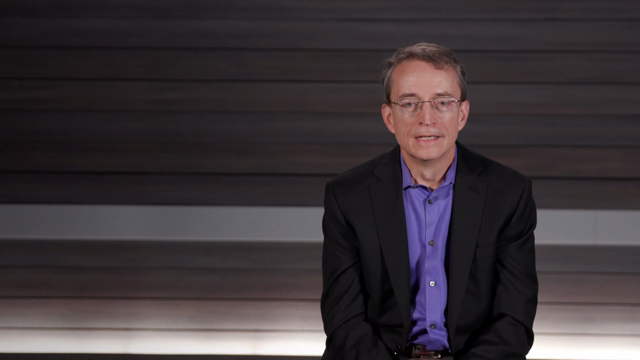

In [6]:
# Source image 640x360 
Image(filename='img_source.png') 

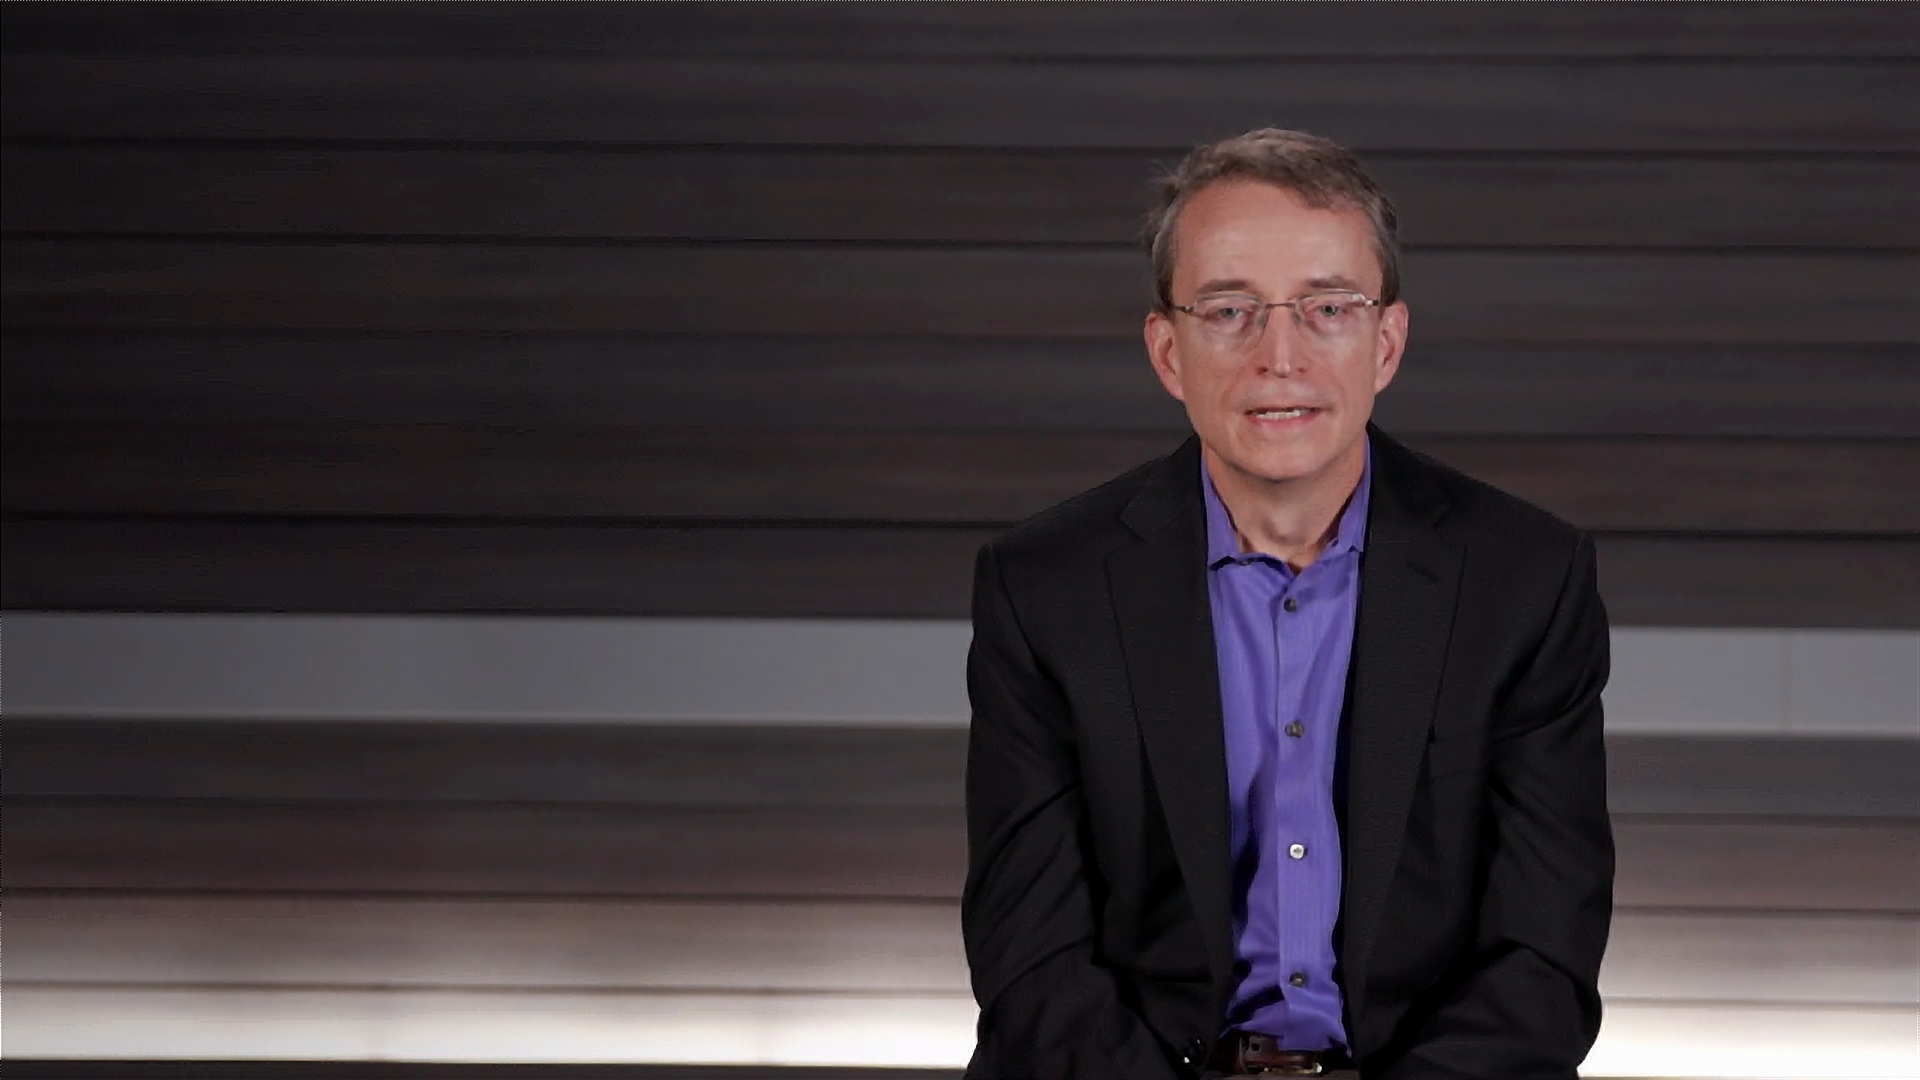

In [8]:
# Super Resolution image 1920x1080
Image(filename='img_superres.png') 

In [ ]:
# Make a directory for the superres upscaled frames
!mkdir frames_upscaled

In [24]:
# This cell shows how to loop through all frames and create superres 1920x1080 images from each 640x360 frame
first_img = 'frames/sr_0001.png'
img = cv.imread(first_img)

inp_h, inp_w = img.shape[0], img.shape[1]
out_h, out_w = inp_h * 3, inp_w * 3  # Do not change! This is how model works

# Setup network
model = 'single-image-super-resolution-1033'
net = IECore().read_network(model=model_xml, weights=model_bin)
function = ng.function_from_cnn(net)

# Reshape network to specific size
net.reshape({'0': [1, 3, inp_h, inp_w], '1': [1, 3, out_h, out_w]})

# Load network to device
ie = IECore()
exec_net = ie.load_network(net, 'CPU')

# Loop through all frames 
frames_dir = 'frames'

for subdir, dirs, files in os.walk(frames_dir):
    for i in files:

        # Read imag
        img = cv.imread(f'frames/{i}')

        # Prepare input
        inp = img.transpose(2, 0, 1)  # interleaved to planar (HWC -> CHW)
        inp = inp.reshape(1, 3, inp_h, inp_w)
        inp = inp.astype(np.float32)

        # Prepare second input - bicubic resize of first input
        resized_img = cv.resize(img, (out_w, out_h), interpolation=cv.INTER_CUBIC)
        resized = resized_img.transpose(2, 0, 1)
        resized = resized.reshape(1, 3, out_h, out_w)
        resized = resized.astype(np.float32)

        outs = exec_net.infer({'0': inp, '1': resized})

        out = next(iter(outs.values()))

        out = out.reshape(3, out_h, out_w).transpose(1, 2, 0)
        out = np.clip(out * 255, 0, 255)
        out = np.ascontiguousarray(out).astype(np.uint8)

        cv.imwrite(f'frames_upscaled/1080_{i}', out)

AttributeError: 'NoneType' object has no attribute 'transpose'

In [28]:
# Create a new video with the frames enhanced by single-image-super-resolution-1033
!ffmpeg -framerate 30 -i frames_upscaled/1080_sr_%04d.png -s 1920x1080 -pix_fmt yuv420p superres_1080.mp4

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.0 (clang-1200.0.32.29)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbo